In [1]:
import os

# for data analytics
import pandas as pd
import numpy as np
from collections import Counter

# for visualizations
import seaborn as sns
import matplotlib.pyplot as plt

# for data preparation
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score

# # hyperopt - used for Bayesian hyperparameter tuning
# from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
# from hyperopt.pyll import scope

# for timing
from time import time
from tqdm import tqdm


In [2]:
!pip install mplfinance

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621

[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python3.9 -m pip install --upgrade pip


In [3]:
broker =  pd.read_csv('../quantitative_data_sample.csv')
broker['date'] = pd.to_datetime(broker['date'])
sentiment =  pd.read_csv('../qualitative_data_sample.csv')
sentiment['date'] = pd.to_datetime(sentiment['date'])

In [4]:
df = pd.merge(broker, sentiment, on='date', how='left')
df.head()

,date,open,high,low,close,volume,priceUsd,is_greater,score
0,2023-03-25 00:00:00+00:00,27487.337891,27791.826172,27196.234375,27494.707031,13383005987,27546.328059,0,0.197584
1,2023-03-24 00:00:00+00:00,28324.111328,28388.437500,27039.265625,27493.285156,25980310960,28022.257161,1,NaN
2,2023-03-23 00:00:00+00:00,27301.957031,28729.843750,27183.363281,28333.972656,24220433689,27852.398940,0,NaN
3,2023-03-22 00:00:00+00:00,28158.720703,28803.335938,26759.996094,27307.437500,33382021890,28110.006364,1,NaN
4,2023-03-21 00:00:00+00:00,27768.392578,28439.562500,27439.646484,28175.816406,36102192830,28013.021553,1,NaN


In [5]:
test_df = df[df['date'] >= '2022-08-01'] # need change to more dynamic 
train_df = df[df['date'] < '2022-07-01']
print(f'size of train dataset: {len(train_df)}')
print(f'size of test dataset: {len(test_df)}')

size of train dataset: 826
size of test dataset: 236


In [6]:
train_df

,date,open,high,low,close,volume,priceUsd,is_greater,score
266,2022-06-30 00:00:00+00:00,20108.312500,20141.160156,18729.656250,19784.726562,26267239923,19349.008753,0,NaN
267,2022-06-29 00:00:00+00:00,20281.169922,20364.156250,19937.791016,20104.023438,23552740328,20145.960169,0,NaN
268,2022-06-28 00:00:00+00:00,20731.544922,21164.423828,20228.812500,20280.634766,21381535161,20708.248615,0,NaN
269,2022-06-27 00:00:00+00:00,21028.238281,21478.089844,20620.199219,20735.478516,20965695707,21048.369066,0,NaN
270,2022-06-26 00:00:00+00:00,21496.494141,21783.724609,21016.269531,21027.294922,18027170497,21355.992372,1,NaN
...,...,...,...,...,...,...,...,...,...
1087,2020-03-31 00:00:00+00:00,6430.606445,6504.515137,6374.162109,6438.644531,32786468812,6458.431322,1,NaN
1088,2020-03-30 00:00:00+00:00,5925.538574,6517.195801,5903.234375,6429.841797,37101651525,6276.327397,1,NaN
1089,2020-03-29 00:00:00+00:00,6245.624512,6250.467285,5920.085938,5922.042969,28373690931,6118.650351,0,NaN
1090,2020-03-28 00:00:00+00:00,6467.253906,6467.500977,6117.837891,6242.193848,34885225901,6237.459370,0,NaN


In [7]:
# handle missing values
numerical_variables = ['open', 'high', 'low', 'close', 'volume', 'priceUsd', 'score']
def clean_numerical_variables(data, var):
    d = data.copy()
    for v in var:
        d.loc[:, v] = d[v].fillna(d[v].mode(),inplace=False, downcast='infer')
    d[var] = d[var].apply(pd.to_numeric, axis=1).astype(np.float32)
    print(d.isnull().sum())
    print(d.dtypes)
    return d

train = clean_numerical_variables(train_df, numerical_variables)
test = clean_numerical_variables(test_df, numerical_variables)

date            0
open            0
high            0
low             0
close           0
volume          0
priceUsd        0
is_greater      0
score         826
dtype: int64
date          datetime64[ns, UTC]
open                      float32
high                      float32
low                       float32
close                     float32
volume                    float32
priceUsd                  float32
is_greater                  int64
score                     float32
dtype: object
date            0
open            0
high            0
low             0
close           0
volume          0
priceUsd        0
is_greater      0
score         211
dtype: int64
date          datetime64[ns, UTC]
open                      float32
high                      float32
low                       float32
close                     float32
volume                    float32
priceUsd                  float32
is_greater                  int64
score                     float32
dtype: object


# EDA

/var/folders/_2/kqv_6ddx3hj55w49w6kgz4_h0000gn/T/ipykernel_15388/2812642038.py:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  axes[index] = plt.subplot(3, 3, index+1, label=str(index))


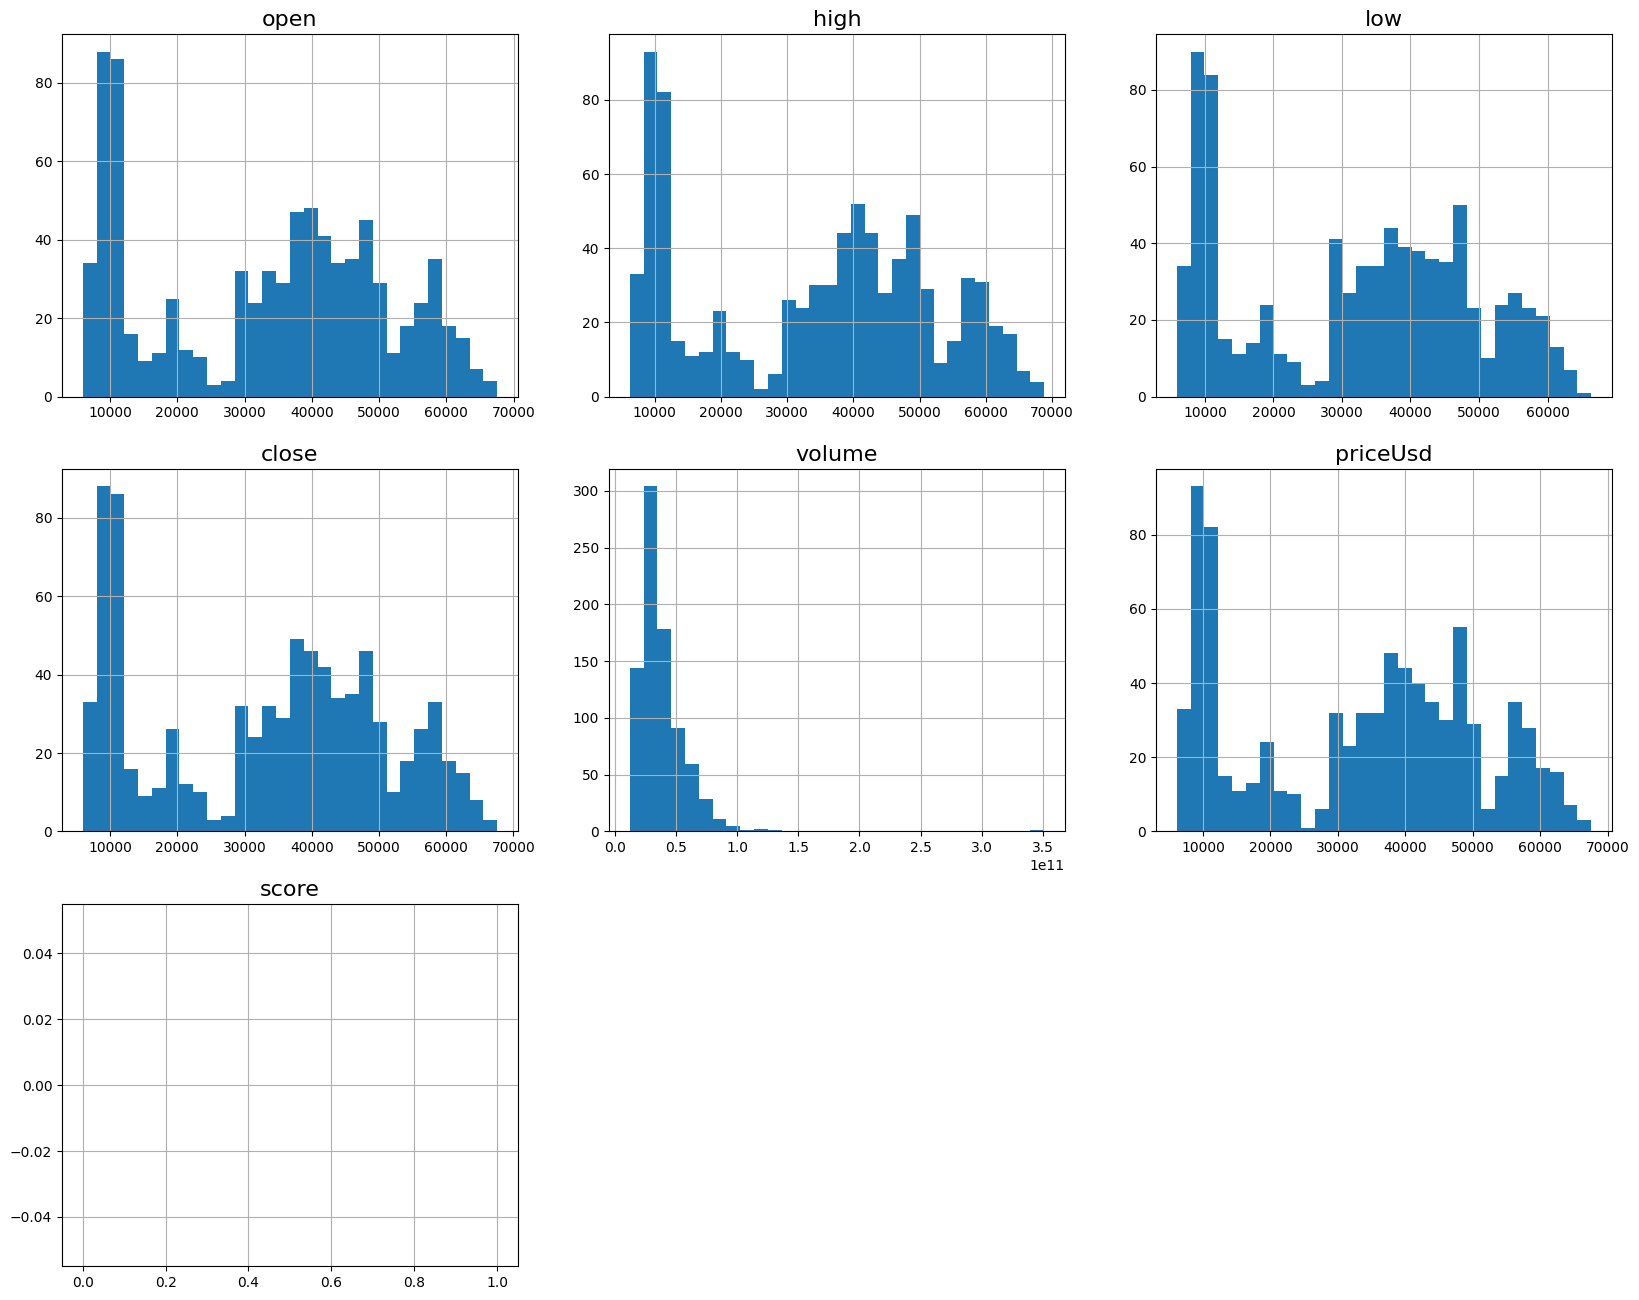

In [8]:
plt.figure(figsize=(20,16))
plt.subplot(321)

axes = [None] * len(numerical_variables)
for index, name in enumerate(train[numerical_variables].columns):
    axes[index] = plt.subplot(3, 3, index+1, label=str(index))
    train[name].hist(ax=axes[index], bins=30)
    axes[index].set_title(name, fontsize=16)

/usr/local/lib/python3.9/site-packages/seaborn/axisgrid.py:1507: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(x=vector, **plot_kwargs)
/usr/local/lib/python3.9/site-packages/seaborn/axisgrid.py:1507: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(x=vector, **plot_kwargs)
/usr/local/lib/python3.9/site-packages/seaborn/axisgrid.py:1507: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(x=vector, **plot_kwargs)
/usr/local/lib/python3.9/site-packages/seaborn/axisgrid.py:1507: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(x=vector, **p

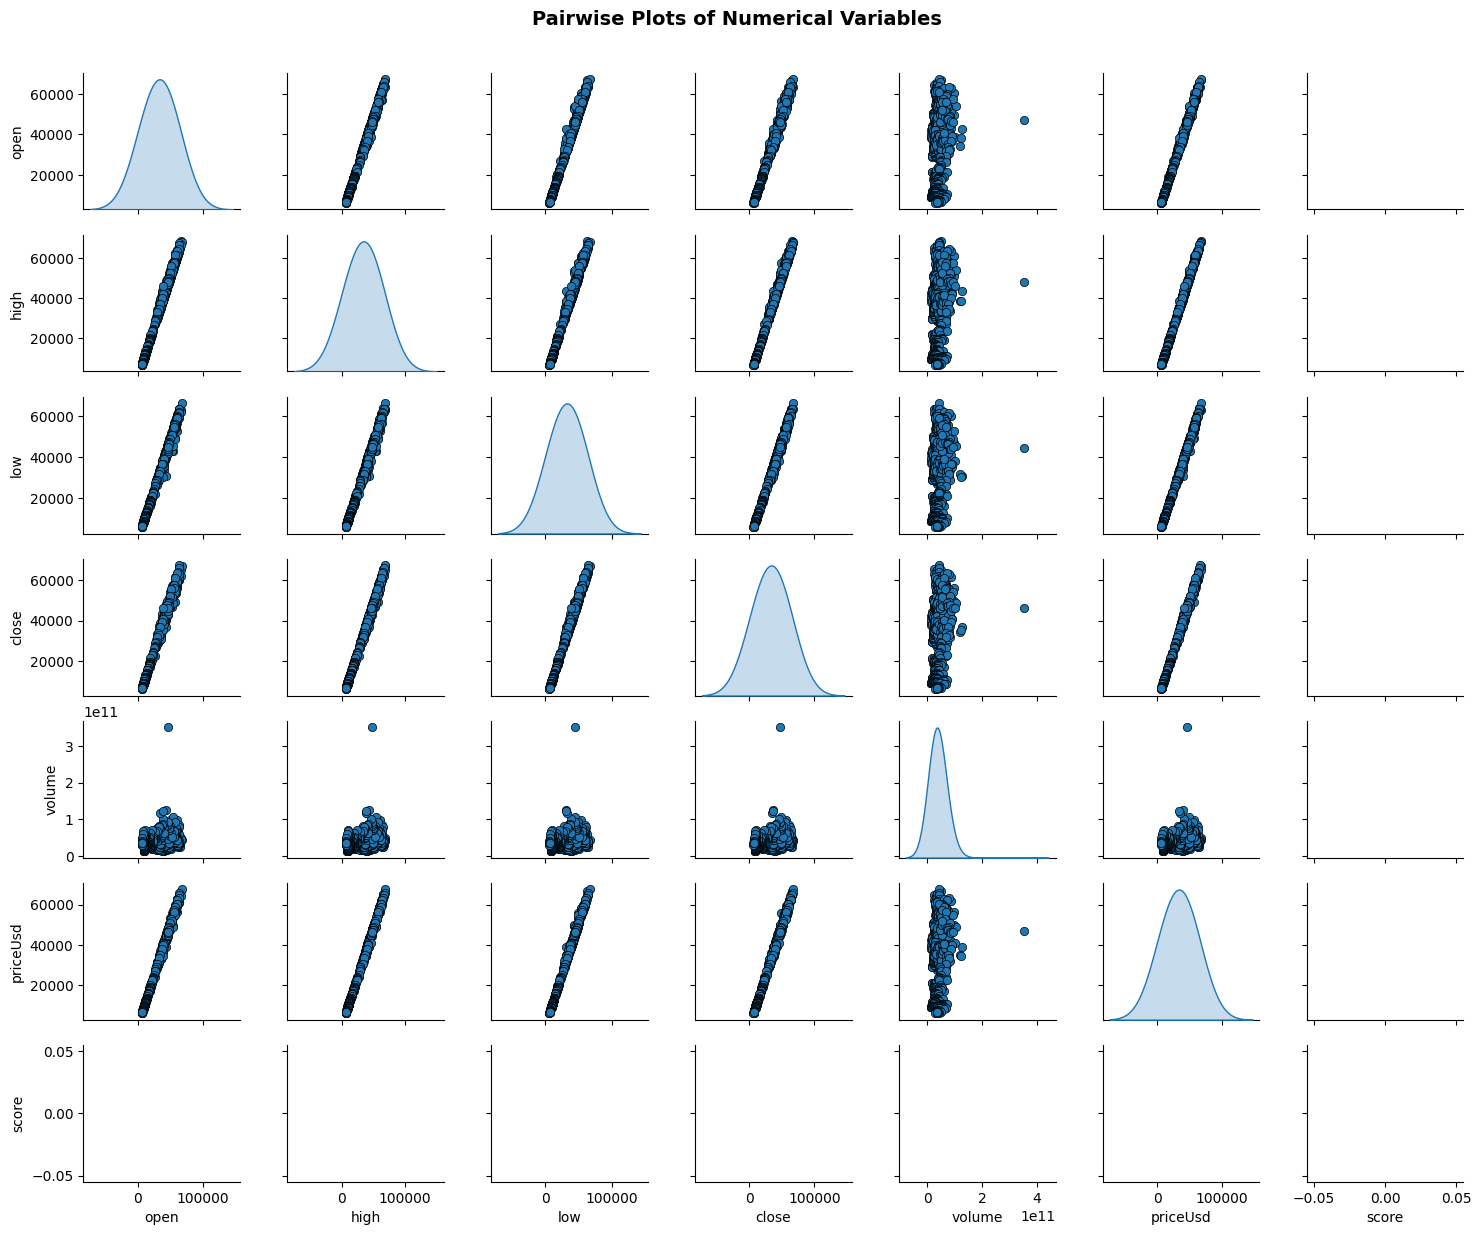

In [9]:
pg = sns.pairplot(train[numerical_variables], 
                  height=1.8, aspect=1.2,
                  plot_kws=dict(edgecolor="k", linewidth=0.5),
                  diag_kind="kde", 
                  diag_kws=dict(shade=True, bw_method=1.5)
                 )
fig = pg.fig 
fig.subplots_adjust(top=0.93, wspace=0.3)
t = fig.suptitle('Pairwise Plots of Numerical Variables', fontsize=14, fontweight='bold')

In [10]:
corr_matrix = train[numerical_variables].corr()

# print the correlation matrix
print(corr_matrix)

              open      high       low     close    volume  priceUsd  score
open      1.000000  0.998699  0.997517  0.996656  0.276974  0.998894    NaN
high      0.998699  1.000000  0.997370  0.998524  0.288631  0.999418    NaN
low       0.997517  0.997370  1.000000  0.998287  0.250605  0.998993    NaN
close     0.996656  0.998524  0.998287  1.000000  0.272085  0.998812    NaN
volume    0.276974  0.288631  0.250605  0.272085  1.000000  0.272277    NaN
priceUsd  0.998894  0.999418  0.998993  0.998812  0.272277  1.000000    NaN
score          NaN       NaN       NaN       NaN       NaN       NaN    NaN


<Axes: xlabel='date'>

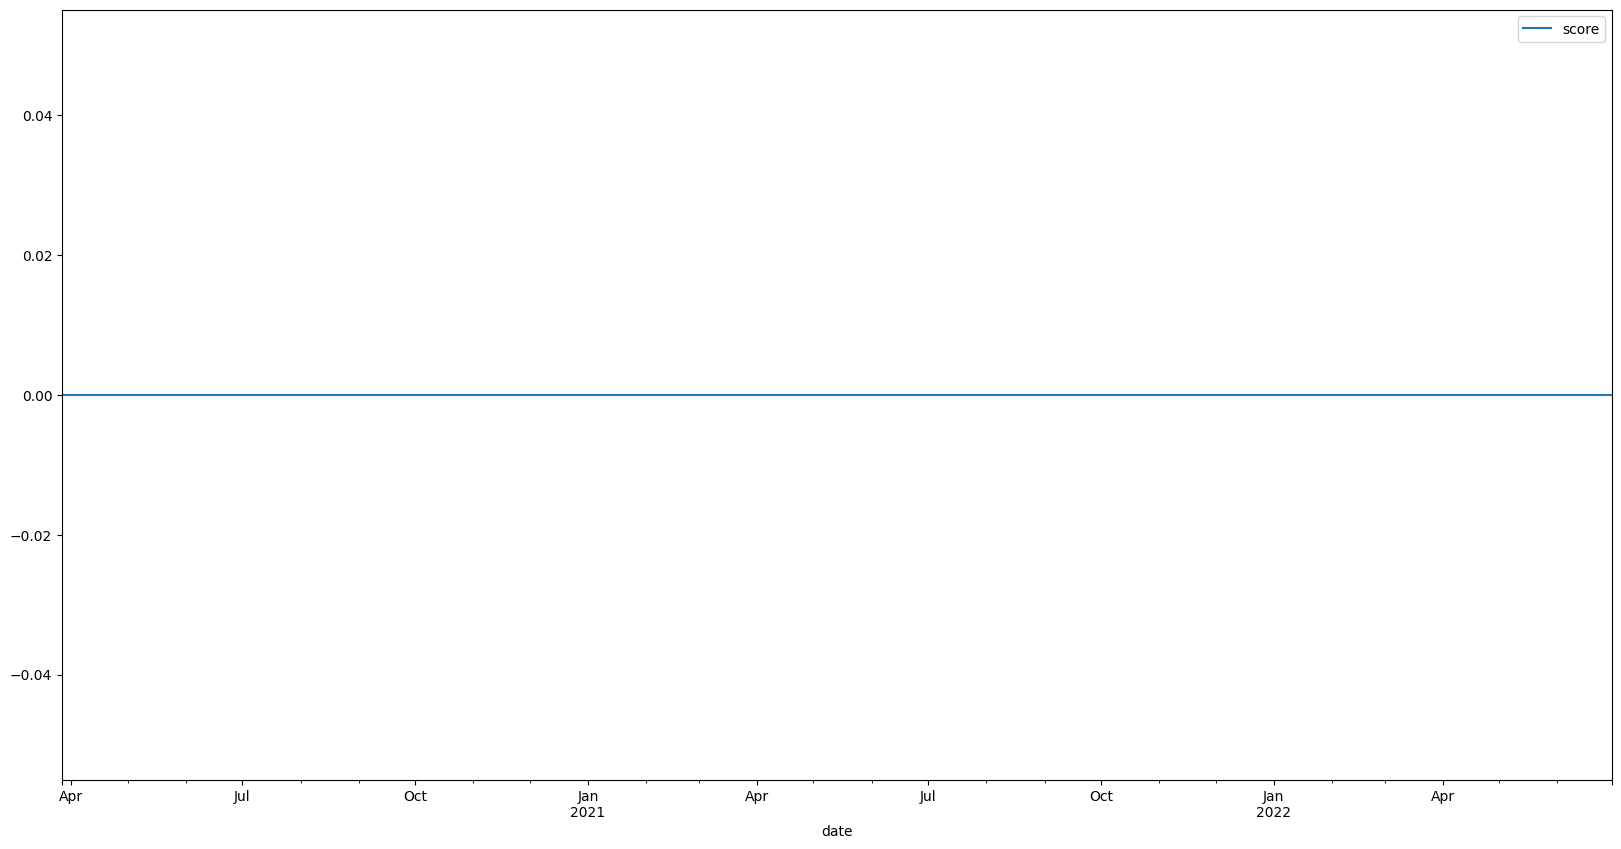

In [11]:
plt.rcParams['figure.figsize'] = (20.0, 10.0)
train[['date', 'score']].set_index('date').resample('D').sum().plot()

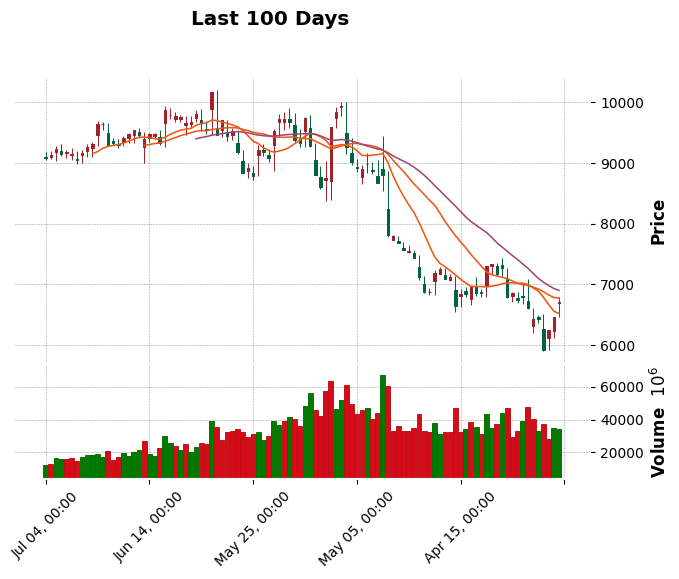

In [12]:
import mplfinance as mpf 
mpf.plot(train[['date', 'open', 'high', 'low', 'volume', 'priceUsd']].rename(columns={'priceUsd':'close'}).set_index("date").tail(100),type="candle", style="charles", volume=True,title="Last 100 Days",
    mav=(10,20,30))

In [13]:
train.head()

,date,open,high,low,close,volume,priceUsd,is_greater,score
266,2022-06-30 00:00:00+00:00,20108.312500,20141.160156,18729.656250,19784.726562,2.626724e+10,19349.007812,0,NaN
267,2022-06-29 00:00:00+00:00,20281.169922,20364.156250,19937.791016,20104.023438,2.355274e+10,20145.960938,0,NaN
268,2022-06-28 00:00:00+00:00,20731.544922,21164.423828,20228.812500,20280.634766,2.138154e+10,20708.248047,0,NaN
269,2022-06-27 00:00:00+00:00,21028.238281,21478.089844,20620.199219,20735.478516,2.096570e+10,21048.369141,0,NaN
270,2022-06-26 00:00:00+00:00,21496.494141,21783.724609,21016.269531,21027.294922,1.802717e+10,21355.992188,1,NaN


# Feature Engineering
- get technical indicators 

In [14]:
import pandas_ta as ta

# calculate the Simple Moving Average (SMA) with period of 20
train['sma'] = ta.sma(train['close'], length=20)  # better for long term trends
test['sma'] = ta.sma(test['close'], length=20) 
# calculate the Exponential Moving Average (EMA) with period of 20 
train['ema'] = ta.ema(train['close'], length=20) # more sensitive to short-term price
test['ema'] = ta.ema(test['close'], length=20)

In [15]:
! pip3 install TA-Lib # use `brew install ta-lib`` first

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621

[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python3.9 -m pip install --upgrade pip


In [16]:
import talib

# calculate RSI with period of 7
test['rsi'] = talib.RSI(test['close'], timeperiod=7)
train['rsi'] = talib.RSI(train['close'], timeperiod=7)

In [17]:
updated_numerical_variables = numerical_variables + ['sma', 'ema', 'rsi']
train[updated_numerical_variables] = train[updated_numerical_variables].apply(pd.to_numeric, axis=1).astype(np.float32)
test[updated_numerical_variables] = test[updated_numerical_variables].apply(pd.to_numeric, axis=1).astype(np.float32)
corr_matrix = train[updated_numerical_variables].corr()  # drop sma 

# print the correlation matrix
print(corr_matrix)

              open      high       low     close    volume  priceUsd  score  \
open      1.000000  0.998699  0.997517  0.996656  0.276974  0.998894    NaN   
high      0.998699  1.000000  0.997370  0.998524  0.288631  0.999418    NaN   
low       0.997517  0.997370  1.000000  0.998287  0.250605  0.998993    NaN   
close     0.996656  0.998524  0.998287  1.000000  0.272085  0.998812    NaN   
volume    0.276974  0.288631  0.250605  0.272085  1.000000  0.272277    NaN   
priceUsd  0.998894  0.999418  0.998993  0.998812  0.272277  1.000000    NaN   
score          NaN       NaN       NaN       NaN       NaN       NaN    NaN   
sma       0.974178  0.976764  0.975163  0.977705  0.281291  0.976225    NaN   
ema       0.979908  0.982512  0.980878  0.983504  0.283450  0.981972    NaN   
rsi       0.342056  0.340538  0.344019  0.342263  0.010801  0.342735    NaN   

               sma       ema       rsi  
open      0.974178  0.979908  0.342056  
high      0.976764  0.982512  0.340538  
low    

In [18]:
train.head()

,date,open,high,low,close,volume,priceUsd,is_greater,score,sma,ema,rsi
266,2022-06-30 00:00:00+00:00,20108.312500,20141.160156,18729.656250,19784.726562,2.626724e+10,19349.007812,0,NaN,NaN,NaN,NaN
267,2022-06-29 00:00:00+00:00,20281.169922,20364.156250,19937.791016,20104.023438,2.355274e+10,20145.960938,0,NaN,NaN,NaN,NaN
268,2022-06-28 00:00:00+00:00,20731.544922,21164.423828,20228.812500,20280.634766,2.138154e+10,20708.248047,0,NaN,NaN,NaN,NaN
269,2022-06-27 00:00:00+00:00,21028.238281,21478.089844,20620.199219,20735.478516,2.096570e+10,21048.369141,0,NaN,NaN,NaN,NaN
270,2022-06-26 00:00:00+00:00,21496.494141,21783.724609,21016.269531,21027.294922,1.802717e+10,21355.992188,1,NaN,NaN,NaN,NaN


## Model Training

In [19]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.models import Sequential


2023-03-27 18:23:51.144744: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [20]:
dv = 'priceUsd'
idv = ['open', 'high', 'low', 'volume',  'rsi', 'ema','priceUsd'] # add sentiment score
train.dtypes

date          datetime64[ns, UTC]
open                      float32
high                      float32
low                       float32
close                     float32
volume                    float32
priceUsd                  float32
is_greater                  int64
score                     float32
sma                       float32
ema                       float32
rsi                       float32
dtype: object

In [21]:
train['rsi'] = train['rsi'].fillna(train['rsi'].mode(),inplace=False, downcast='infer')
test['rsi'] = test['rsi'].fillna(test['rsi'].mode(),inplace=False, downcast='infer')
train['ema'] = train['ema'].fillna(train['ema'].mode(),inplace=False, downcast='infer')
test['ema'] = test['ema'].fillna(test['ema'].mode(),inplace=False, downcast='infer')

In [22]:
# train.drop(['date', 'score'], inplace = True, axis=1)
# test.drop(['date', 'score'], inplace = True,axis=1) # drop score first

In [23]:
train = train.set_index("date") # Make the Close time the index
test = test.set_index("date") # Make the Close time the index
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(train[dv].values.reshape(-1,1))
# scaled_test_data = scaler.transform(test['close'].values.reshape(-1,1))

In [24]:
#Prediction Day
prediction_days = 7 # Number of days the neural network will predict

In [25]:
scaled_data.shape

(826, 1)

In [26]:
x_train, y_train = [], []
for x in range(prediction_days, len(scaled_data)):
 x_train.append(scaled_data[x-prediction_days:x, 0])
 y_train.append(scaled_data[x, 0])
 
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [27]:
x_train.shape[1]

7

In [28]:
model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1), activation='relu'))
model.add(Dropout(0.2)) # To prevent overfitting
model.add(LSTM(units=50, return_sequences=True,activation='relu'))
model.add(Dropout(0.2)) # To prevent overfitting
model.add(LSTM(units=40))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(x_train, y_train, epochs=50, batch_size=64, validation_split=0.1)

Epoch 1/50


2023-03-27 18:23:55.168089: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-27 18:23:55.169090: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-27 18:23:55.171227: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

 7/12 [================>.............] - ETA: 0s - loss: 0.2476 

2023-03-27 18:23:59.165589: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-27 18:23:59.166610: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-27 18:23:59.168145: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

12/12 [==============================] - 4s 65ms/step - loss: 0.2118 - val_loss: 0.0322
Epoch 2/50
12/12 [==============================] - 0s 10ms/step - loss: 0.0526 - val_loss: 0.1297
Epoch 3/50
12/12 [==============================] - 0s 10ms/step - loss: 0.0334 - val_loss: 0.0518
Epoch 4/50
12/12 [==============================] - 0s 11ms/step - loss: 0.0199 - val_loss: 0.0437
Epoch 5/50
12/12 [==============================] - 0s 11ms/step - loss: 0.0126 - val_loss: 0.0126
Epoch 6/50
12/12 [==============================] - 0s 11ms/step - loss: 0.0081 - val_loss: 0.0031
Epoch 7/50
12/12 [==============================] - 0s 10ms/step - loss: 0.0071 - val_loss: 0.0019
Epoch 8/50
12/12 [==============================] - 0s 11ms/step - loss: 0.0066 - val_loss: 0.0021
Epoch 9/50
12/12 [==============================] - 0s 10ms/step - loss: 0.0061 - val_loss: 0.0012
Epoch 10/50
12/12 [==============================] - 0s 10ms/step - loss: 0.0066 - val_loss: 8.8459e-04
Epoch 11/50
12/1

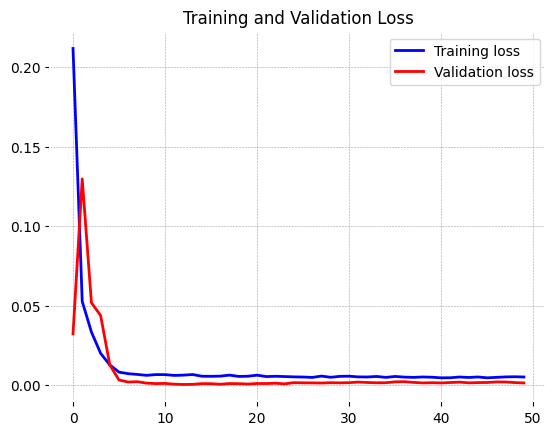

In [29]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

In [30]:
## To save or load the model uncomment this
# from keras.models import load_model
# # save the model 
# model.save('is3107_crypto_model.h5')
# # load the model
# model = load_model('is3107_crypto_model.h5')

In [31]:
total_dataset = pd.concat((train[dv], test[dv]), axis=0)


model_inputs = total_dataset[len(total_dataset) - len(test) - prediction_days:].values
model_inputs = model_inputs.reshape(-1, 1)
model_inputs = scaler.fit_transform(model_inputs)

x_test = []

for x in range(prediction_days, len(model_inputs)):
    x_test.append(model_inputs[x-prediction_days:x, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))


#Predict model based on test data
y_pred = model.predict(x_test)
y_pred = scaler.inverse_transform(y_pred)

2023-03-27 18:24:06.561804: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-27 18:24:06.562841: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-27 18:24:06.564368: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

8/8 [==============================] - 1s 4ms/step


In [32]:
# Calculate the MAE
y_actual =np.array(test[dv])
mae = np.mean(np.abs(y_pred - y_actual))
print("MAE: {:.2f}".format(mae))

# Calculate the RMSE
rmse = np.sqrt(np.mean(np.square(y_pred - y_actual)))
print("RMSE: {:.2f}".format(rmse))

MAE: 3205.17
RMSE: 4097.39


In [33]:
# Normalize the MAE and RMSE using min-max scaling
mae_norm = (mae - np.min([mae, rmse])) / (np.max([mae, rmse]) - np.min([mae, rmse]))
rmse_norm = (rmse - np.min([mae, rmse])) / (np.max([mae, rmse]) - np.min([mae, rmse]))

print("Normalized MAE: {:.2f}".format(mae_norm))
print("Normalized RMSE: {:.2f}".format(rmse_norm))

Normalized MAE: 0.00
Normalized RMSE: 1.00


In [34]:
predicted_df = pd.DataFrame(y_pred, columns=['predicted_price'])
test.reset_index(inplace=True)
res_df = pd.concat([test, predicted_df], axis = 1) 
res_df

,date,open,high,low,close,volume,priceUsd,is_greater,score,sma,ema,rsi,predicted_price
0,2023-03-25 00:00:00+00:00,27487.337891,27791.826172,27196.234375,27494.707031,1.338301e+10,27546.328125,0,0.197584,NaN,16619.425781,7.742073,7586.345703
1,2023-03-24 00:00:00+00:00,28324.111328,28388.437500,27039.265625,27493.285156,2.598031e+10,28022.257812,1,0.109447,NaN,16628.199219,7.798915,8154.826172
2,2023-03-23 00:00:00+00:00,27301.957031,28729.843750,27183.363281,28333.972656,2.422043e+10,27852.398438,0,0.140434,NaN,16631.865234,8.104498,9552.799805
3,2023-03-22 00:00:00+00:00,28158.720703,28803.335938,26759.996094,27307.437500,3.338202e+10,28110.005859,1,0.177499,NaN,16634.826172,8.158389,11811.259766
4,2023-03-21 00:00:00+00:00,27768.392578,28439.562500,27439.646484,28175.816406,3.610219e+10,28013.021484,1,0.188738,NaN,16639.843750,8.168549,14853.278320
...,...,...,...,...,...,...,...,...,...,...,...,...,...
231,2022-08-05 00:00:00+00:00,22626.833984,23422.828125,22612.177734,23289.314453,2.888125e+10,23070.486328,1,NaN,22996.021484,22895.966797,50.714008,22858.933594
232,2022-08-04 00:00:00+00:00,22848.214844,23198.009766,22485.701172,22630.957031,2.512023e+10,22858.412109,0,NaN,23057.818359,22870.726562,39.913857,22743.925781
233,2022-08-03 00:00:00+00:00,22981.302734,23578.650391,22747.835938,22846.507812,2.628817e+10,23179.566406,1,NaN,23123.740234,22868.419922,44.433937,22519.908203
234,2022-08-02 00:00:00+00:00,23308.433594,23415.041016,22710.083984,22978.117188,2.838925e+10,22982.857422,0,NaN,23202.699219,22878.867188,47.260090,22469.693359


In [35]:
res_df.set_index('date', inplace=True)

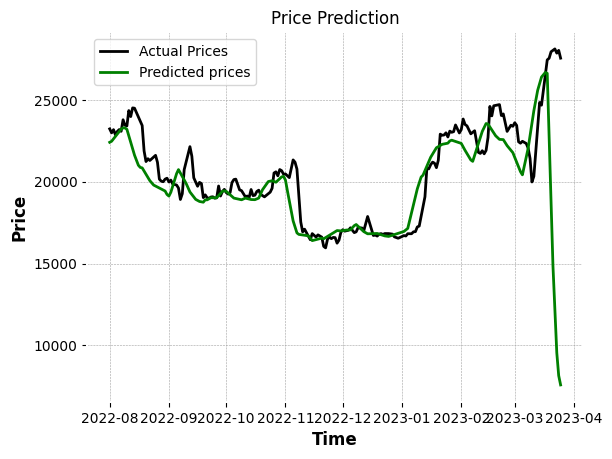

In [36]:
plt.plot(res_df[dv], color="black", label="Actual Prices")
plt.plot(res_df['predicted_price'], color="green", label="Predicted prices")
plt.title("Price Prediction")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend(loc="upper left")
plt.show()